In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from similarity_searching_sketches.multi_hash_index_stats import ListStatsCounter
from similarity_searching_sketches.multi_hash_index_stats import bucket_stats
from similarity_searching_sketches.multi_hash_index_stats import bucket_sizes
from similarity_searching_sketches.multi_hash_index_stats import stats_to_pandas
from similarity_searching_sketches.multi_hash_index_stats import rq_candidate_set_size_stats
from similarity_searching_sketches.multi_hash_index import MultiHashIndex
from similarity_searching_sketches.persistence import load_np_array
from similarity_searching_sketches.utils import df_to_latex
from similarity_searching_sketches.visualization import hist_array
from similarity_searching_sketches.visualization import plot_array
% matplotlib inline


In [2]:
DATA_FOLDER = '/home/matej/data/sketch-testing/dataset_10K/'
PIVOTS_PATH = DATA_FOLDER + 'selected_pivots.npy'
MHI_DB_SAVE_PATH = DATA_FOLDER + 'mhi_sketch_db.npy'
BUCKET_STATS_LATEX_SAVE_FILE = DATA_FOLDER + 'bucket_stats.tex'
CANDIDATE_SET_SIZE_STATS_LATEX_SAVE_FILE = DATA_FOLDER + 'candidate_set_size_stats.tex'
SKETCH_LEN = 16
N_QUERY_OBJS = 100
MAX_M = 8


#### Prepare Sketch DB

In [3]:
sketch_db = load_np_array(MHI_DB_SAVE_PATH).T[:SKETCH_LEN].T


In [4]:
ids = np.arange(sketch_db.shape[0])


In [5]:
db = [(ids[i], sketch_db[i]) for i in range(sketch_db.shape[0])]
random.shuffle(db)
queries = db[:N_QUERY_OBJS]
sketch_db = db[N_QUERY_OBJS:]
del db


In [6]:
len(sketch_db)


9900

#### Initialize MHI's

In [7]:
m_list = range(1, MAX_M + 1, 1)
mhis = [MultiHashIndex(sketch_db, m) for m in m_list]


#### Compute stats  for MHI's buckets

In [8]:
bucket_stats_keys, bucket_stats = bucket_stats(mhis, m_list)


In [9]:
bucket_stats_df = stats_to_pandas(bucket_stats_keys, bucket_stats)


/home/matej/project/similarity-searching-sketches/similarity_searching_sketches/multi_hash_index_stats.py:21: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  return pd.DataFrame.from_dict({key: stats[key] for key in keys}).reindex_axis(keys, axis=1)


In [10]:
bucket_stats_df


,m,r,Bucket count,Bucket size mean,Bucket size sum,m x Bucket size mean
0,1,0,5250,1.885714,9900,1.885714
1,2,1,484,40.909091,19800,81.818182
2,3,2,128,232.031250,29700,696.093750
3,4,3,64,618.750000,39600,2475.000000
4,5,4,48,1031.250000,49500,5156.250000
5,6,5,40,1485.000000,59400,8910.000000
6,7,6,36,1925.000000,69300,13475.000000
7,8,7,32,2475.000000,79200,19800.000000


In [11]:
df_to_latex(BUCKET_STATS_LATEX_SAVE_FILE, bucket_stats_df)


#### Visualize bucket sizes

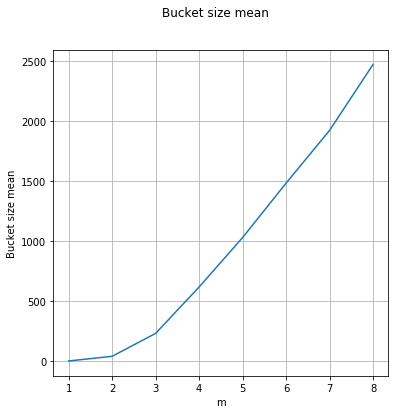

In [12]:
plot_array([None] + list(bucket_stats_df['Bucket size mean'].values), title='Bucket size mean', xlabel='m',
           ylabel='Bucket size mean', figsize=(6, 6))


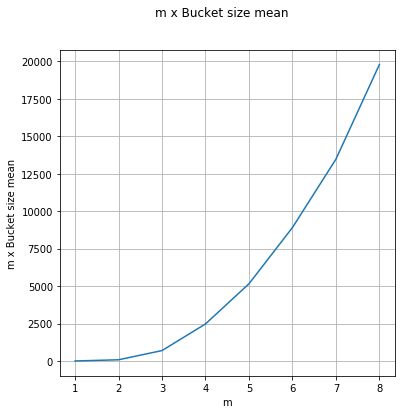

In [13]:
plot_array([None] + list(bucket_stats_df['m x Bucket size mean'].values), title='m x Bucket size mean', xlabel='m',
           ylabel='m x Bucket size mean', figsize=(6, 6))


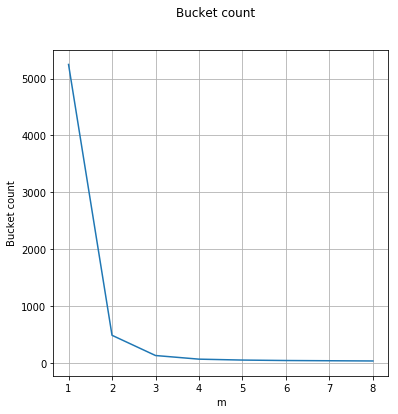

In [14]:
plot_array([None] + list(bucket_stats_df['Bucket count'].values), title='Bucket count', xlabel='m',
           ylabel='Bucket count', figsize=(6, 6))


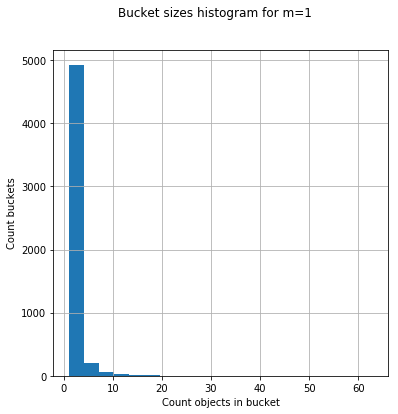

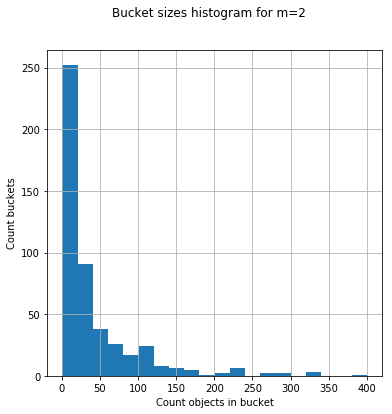

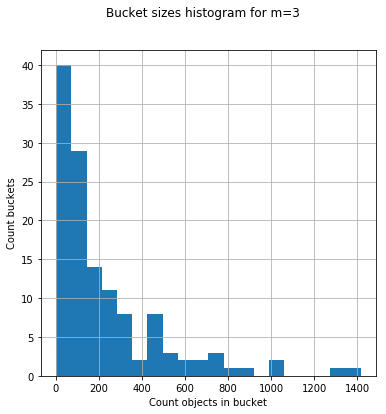

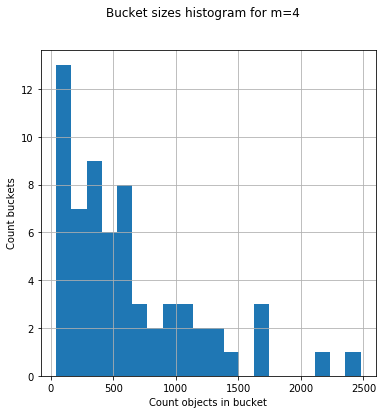

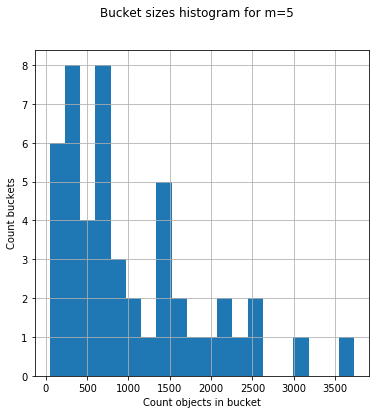

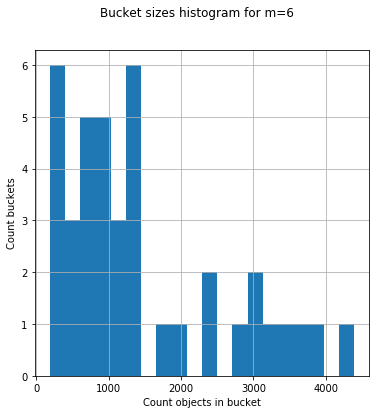

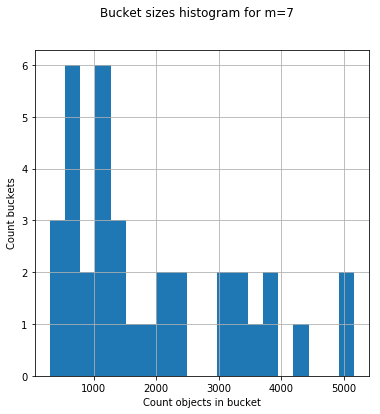

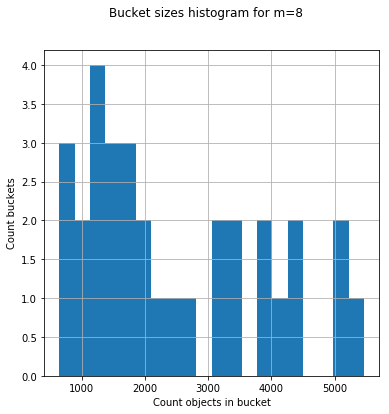

In [15]:
for i, mhi in enumerate(mhis):
    m = m_list[i]
    hist_array(bucket_sizes(mhi), bins=20, title='Bucket sizes histogram for m=' + str(m),
               xlabel='Count objects in bucket', ylabel='Count buckets', figsize=(6, 6))


#### Range query candidate set sizes

In [16]:
keys, stats = rq_candidate_set_size_stats(queries, mhis, m_list, len(sketch_db))
candidate_set_stats_df = stats_to_pandas(keys, stats)


/home/matej/project/similarity-searching-sketches/similarity_searching_sketches/multi_hash_index_stats.py:21: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  return pd.DataFrame.from_dict({key: stats[key] for key in keys}).reindex_axis(keys, axis=1)


In [17]:
candidate_set_stats_df


,m,r,Mean TP count,m x Bucket size mean,Mean |C_1|+...+|C_m|,Mean |C|,Mean % bucket overlap,Mean % db filtered
0,1,0,4.09,1.885714,4.09,4.09,0.000000,99.958687
1,2,1,32.40,81.818182,221.68,217.59,1.845002,97.802121
2,3,2,150.92,696.093750,1561.34,1462.64,6.321493,85.225859
3,4,3,495.62,2475.000000,4101.93,3424.64,16.511496,65.407677
4,5,4,1257.68,5156.250000,8292.10,5854.75,29.393640,40.861111
5,6,5,2561.43,8910.000000,13864.14,7826.59,43.547959,20.943535
6,7,6,4326.62,13475.000000,19794.12,8921.41,54.928989,9.884747
7,8,7,6207.82,19800.000000,25735.23,9417.68,63.405495,4.871919


In [18]:
df_to_latex(CANDIDATE_SET_SIZE_STATS_LATEX_SAVE_FILE, candidate_set_stats_df)


/home/matej/project/similarity-searching-sketches/similarity_searching_sketches/multi_hash_index_stats.py:21: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  return pd.DataFrame.from_dict({key: stats[key] for key in keys}).reindex_axis(keys, axis=1)


Text(0,0.5,"Count object ID's")

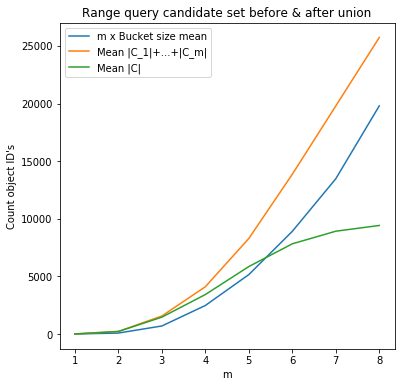

In [19]:
candidate_set_stats_df_with_m0 = stats_to_pandas(keys, {key: [None] + stats[key] for key in stats.keys()})
candidate_set_stats_df_with_m0[['m x Bucket size mean', 'Mean |C_1|+...+|C_m|', 'Mean |C|']].plot(figsize=(6, 6))
plt.title('Range query candidate set before & after union')
plt.xlabel('m')
plt.ylabel('Count object ID\'s')
